In [24]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from CL_utilities.ContrastiveGenerator import ContrastiveGenerator
from distance.CL_Euclidean_Distance import CL_Euclidean_Distance
from CL_utilities.CL_mapping import Generate_pack_of_images
from CL_utilities import CL_visualization
from CL_utilities import CL_loss


In [25]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

In [26]:
path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
# path = r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training"
# path = r"C:\Users\matim\Documents\FruitDataset\archive"

number_of_pairs = 200 #16   # WE Create number_of_pairs * 2  pairs.
generator = ContrastiveGenerator(path, number_of_pairs)

27


# Generator for creating dataset

In [27]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

# Create new pack of images and label

In [28]:
IMAGE_SIZE = (258, 320)

pack_of_images = Generate_pack_of_images(IMAGE_SIZE, batch_size)
img_pack = dataset.map( lambda image_path1, image_path2, value: (pack_of_images(image_path1, image_path2, value))).batch(batch_size)
touple_of_products = img_pack

print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


# (1.) See Documentation to get info about structure of dataset

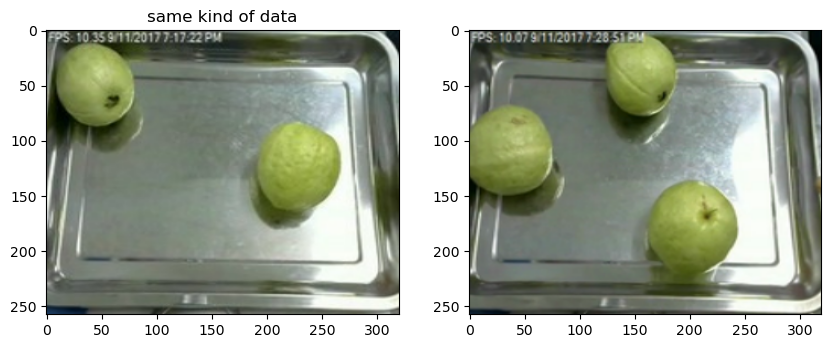

Etykieta: 0


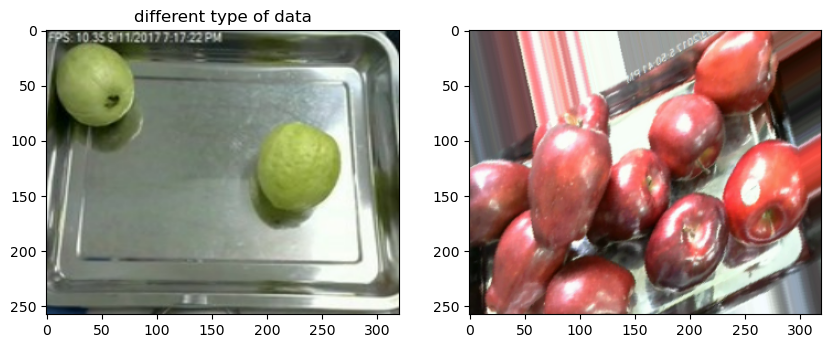

Etykieta: 1


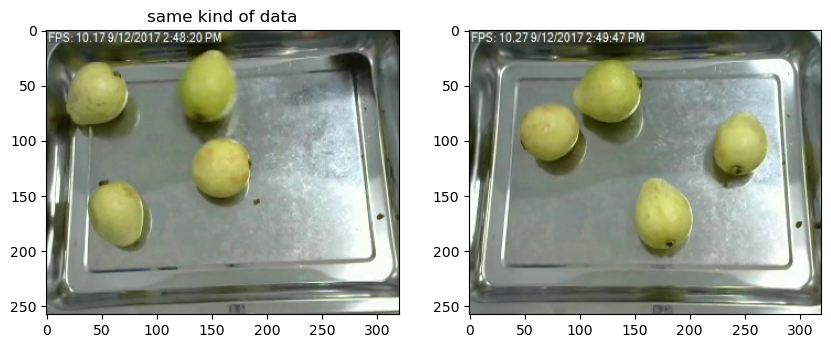

Etykieta: 0


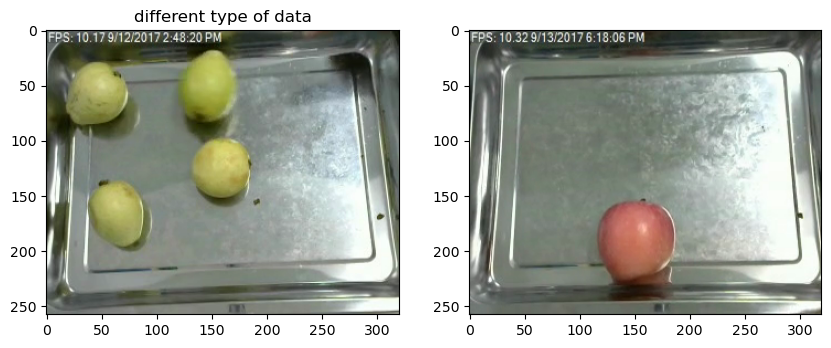

Etykieta: 1


In [30]:
CL_visualization.visualize(touple_of_products)

In [31]:
import keras

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [32]:
input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

euclidean_distance = CL_Euclidean_Distance()
merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [33]:
siamese.compile(loss=CL_loss.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 258, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 258, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 16)           19830556    ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

In [34]:
# How many samples we have, and how many we want in train and validation
num_samples = sum(1 for _ in touple_of_products)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
# .take() to get from actual batch
train_dataset = touple_of_products.take(train_size)
val_dataset = touple_of_products.skip(train_size)


Trained_model_data = siamese.fit(train_dataset, 
                                 validation_data= val_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10


2024-04-08 21:35:33.760490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


     40/Unknown - 28s 660ms/step - loss: 0.3267 - accuracy: 0.4594

2024-04-08 21:36:01.725358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 30s 704ms/step - loss: 0.3267 - accuracy: 0.4594 - val_loss: 0.5012 - val_accuracy: 0.5000
Epoch 2/10
40/40 [==============================] - 28s 695ms/step - loss: 0.3092 - accuracy: 0.5094 - val_loss: 0.3721 - val_accuracy: 0.4500
Epoch 3/10
40/40 [==============================] - 28s 693ms/step - loss: 0.3119 - accuracy: 0.4750 - val_loss: 0.4019 - val_accuracy: 0.4000
Epoch 4/10
40/40 [==============================] - 29s 724ms/step - loss: 0.3119 - accuracy: 0.4531 - val_loss: 0.3559 - val_accuracy: 0.3750
Epoch 5/10
40/40 [==============================] - 29s 720ms/step - loss: 0.2996 - accuracy: 0.4469 - val_loss: 0.3407 - val_accuracy: 0.4250
Epoch 6/10
40/40 [==============================] - 28s 694ms/step - loss: 0.3194 - accuracy: 0.4406 - val_loss: 0.3183 - val_accuracy: 0.4875
Epoch 7/10
40/40 [==============================] - 29s 714ms/step - loss: 0.3020 - accuracy: 0.4406 - val_loss: 0.3087 - val_accuracy: 0.4375
Epoch 8/10